# Latitude Take-Home Analysis
**Author:** Marcus Chen  
**Date:** 2025-10-20


## Table of Contents
1. **Data Quality & Instrumentation**
2. **First-Time User Experience (FTUE)**
3. **Content Performance & Recommendations**
4. **Summary & Next Steps**


In [20]:
import os
import json
import uuid
import re
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq


---
# 1. Data Quality & Instrumentation

**Goals**
- Load the data
- Identify missing/invalid fields, duplicates, temporal anomalies, attribution gaps.
- Propose fixes.



## 1.1 Data Loading

In [12]:
# ==== CONFIG ====
CSV_PATH = "latitude_event_data.csv"           # Raw CSV (~GB scale)
PARQUET_DIR = "parquet"               # Output directory (partitioned by dt=YYYY-MM-DD)
CHUNK = 500_000                                # Chunk size for streaming read (tune for your RAM)

Path(PARQUET_DIR).mkdir(parents=True, exist_ok=True)


def _safe_json(cell):
    """
    Parse a JSON string into dict safely.
    Returns {} when input is not a string or parsing fails.
    (We keep it lightweight to avoid exceptions bubbling out of the chunk loop.)
    """
    if isinstance(cell, str):
        try:
            return json.loads(cell)
        except Exception:
            return {}
    return {}


def parse_meta(cell):
    """
    Extract selected fields from the 'metadata' JSON cell into flat columns.
    NOTE:
    - We access both top-level and nested 'clientInfo' and 'params'.
    - Returns a pandas.Series with consistent keys (missing values become NaN after concat).
    """
    d = _safe_json(cell)
    client = d.get("clientInfo", {}) or {}
    params = d.get("params", {}) or {}

    return pd.Series(
        {
            # top-level
            "platform": d.get("platform"),
            "userAgent": d.get("userAgent"),
            "path": d.get("path"),
            "ipAddress": d.get("ipAddress"),
            "releaseStage": d.get("releaseStage"),

            "adventureId": d.get("adventureId"),
            "scenarioId": d.get("scenarioId"),
            "actionType": d.get("actionType"),

            # nested: clientInfo.*
            "client_platform": client.get("platform"),
            "client_userAgent": client.get("userAgent"),
            "client_path": client.get("path"),
            "client_adventureId": client.get("adventureId"),
            "client_scenarioId": client.get("scenarioId"),
            "client_actionType": client.get("actionType"),

            # nested: params.*
            "param_username": params.get("username"),
            "param_id": params.get("id"),
        }
    )


def _build_event_ts(chunk: pd.DataFrame) -> pd.Series:
    """
    Build a UTC timestamp column 'event_ts' robustly.
    Heuristics:
    1) If a true timestamp column exists (e.g., 'created_at' looks like ISO), parse that first.
    2) Else if y/m/d/h exist, attempt to compose from parts; optionally use minute/second if present.
    3) Otherwise return NaT.

    This is safer than forcing 'created_at' into the 'hour:created_at' slot, which may be wrong if
    'created_at' is already a full timestamp string.
    """
    # Case 1: Prefer a directly parsable timestamp column if available
    if "created_at" in chunk.columns:
        ts = pd.to_datetime(chunk["created_at"], errors="coerce", utc=True)
        if ts.notna().any():
            return ts

    # Case 2: Build from components if present
    needed = {"year", "month", "day", "hour"}
    if needed.issubset(chunk.columns):
        # Optional pieces
        minute_col = "minute" if "minute" in chunk.columns else None
        second_col = "second" if "second" in chunk.columns else None

        # Compose a string like "YYYY-MM-DD HH:MM:SS"
        y = chunk["year"].astype("Int64").astype(str)
        m = chunk["month"].astype("Int64").astype(str)
        d = chunk["day"].astype("Int64").astype(str)
        h = chunk["hour"].astype("Int64").astype(str)

        mm = chunk[minute_col].astype("Int64").astype(str) if minute_col else "00"
        ss = chunk[second_col].astype("Int64").astype(str) if second_col else "00"

        # When mm/ss are scalars, broadcast them
        if isinstance(mm, str):
            mm = pd.Series(["00"] * len(chunk), index=chunk.index)
        if isinstance(ss, str):
            ss = pd.Series(["00"] * len(chunk), index=chunk.index)

        composed = y + "-" + m + "-" + d + " " + h + ":" + mm + ":" + ss
        return pd.to_datetime(composed, errors="coerce", utc=True)

    # Fallback
    return pd.Series(pd.NaT, index=chunk.index, dtype="datetime64[ns, UTC]")


# === Stream CSV -> Enrich -> Partitioned Parquet ===
for i, chunk in enumerate(pd.read_csv(CSV_PATH, chunksize=CHUNK, low_memory=False)):
    # 1) Normalize user_id to string early to avoid downstream dtype inconsistency.
    if "user_id" in chunk.columns:
        chunk["user_id"] = chunk["user_id"].astype(str)

    # 2) Build event_ts (UTC) with a robust helper
    chunk["event_ts"] = _build_event_ts(chunk)

    # 3) Expand metadata JSON into flat columns (only if present)
    if "metadata" in chunk.columns:
        # NOTE: apply + small Series return is fine for clarity; for speed, consider json_normalize after mapping to dicts.
        meta = chunk["metadata"].apply(parse_meta)
        chunk = pd.concat([chunk, meta], axis=1)

    # 4) Partition key 'dt' = YYYY-MM-DD (string)
    chunk["dt"] = chunk["event_ts"].dt.strftime("%Y-%m-%d").fillna("unknown")

    # 5) Select a stable column subset for Parquet (only keep what you need downstream)
    keep_cols = [
        "event_ts", "event_type", "event_name", "event_variation", "user_id",
        "account_created_at", "verified_at",
        "platform", "userAgent", "path", "ipAddress", "releaseStage",
        "adventureId", "scenarioId", "actionType",
        "client_platform", "client_userAgent", "client_path",
        "client_adventureId", "client_scenarioId", "client_actionType",
        "param_username", "param_id",
        "dt",
    ]
    existing = [c for c in keep_cols if c in chunk.columns]
    out = chunk[existing].copy()

    # 6) Write partitioned Parquet by date
    for dt_value, df_dt in out.groupby("dt", dropna=False):
        subdir = Path(PARQUET_DIR) / f"dt={dt_value}"
        subdir.mkdir(parents=True, exist_ok=True)
        pq.write_table(
            pa.Table.from_pandas(df_dt, preserve_index=False),
            subdir / f"part-{uuid.uuid4().hex}.parquet",
            compression="zstd",
        )

    print(f"Chunk {i} done ({len(chunk)} rows)")

print("CSV → Parquet Completed")


Chunk 0 done (500000 rows)
Chunk 1 done (500000 rows)
Chunk 2 done (500000 rows)
Chunk 3 done (500000 rows)
Chunk 4 done (500000 rows)
Chunk 5 done (500000 rows)
Chunk 6 done (500000 rows)
Chunk 7 done (500000 rows)
Chunk 8 done (500000 rows)
Chunk 9 done (500000 rows)
Chunk 10 done (500000 rows)
Chunk 11 done (500000 rows)
Chunk 12 done (500000 rows)
Chunk 13 done (444203 rows)
CSV → Parquet Completed


In [13]:
PARQUET_DIR = "parquet"

def list_parquet_files(root: str):
    """
    Recursively yield all Parquet file paths under a given root directory.
    """
    for r, _, fs in os.walk(root):
        for fn in fs:
            if fn.endswith(".parquet"):
                p = os.path.join(r, fn)
                if os.path.isfile(p):
                    yield p

frames = []

for p in list_parquet_files(PARQUET_DIR):
    pf = pq.ParquetFile(p)
    t = pf.read()  # pyarrow.Table

    # Ensure 'dt' column is string type.
    if "dt" in t.column_names and not pa.types.is_string(t["dt"].type):
        t = t.set_column(t.column_names.index("dt"), "dt", t["dt"].cast(pa.string()))

    # Convert to pandas DataFrame.
    pdf = t.to_pandas(types_mapper=None)

    # Add or enforce 'dt' column as string.
    if "dt" in pdf.columns:
        pdf["dt"] = pdf["dt"].astype(str)
    else:
        m = re.search(r"dt=([^/\\]+)", p)
        pdf["dt"] = m.group(1) if m else "unknown"

    frames.append(pdf)

# Combine all DataFrames.
df = pd.concat(frames, ignore_index=True)
print("Loaded rows:", len(df))


Loaded rows: 6944203


## 1.2 Standard Data Checking

In [35]:
# =====================================
# Data Quality Checks and Surface Mapping
# =====================================

import pandas as pd

# Columns to check for missing values
cols_check = [
    c for c in [
        "event_ts", "event_type", "event_name", "user_id",
        "path", "scenarioId", "adventureId", "userAgent", "platform",
        "account_created_at", "verified_at"
    ] if c in df.columns
]

# Calculate null rate (%) per column
dq_null = (df[cols_check].isna().mean().sort_values(ascending=False) * 100).round(2)
print("[Null Rates %]")
print(dq_null)

# Detect potential duplicate rows based on key identifiers
dup_keys = [k for k in ["user_id", "event_name", "event_ts", "scenarioId", "adventureId"] if k in df.columns]
dup_cnt = df.duplicated(subset=dup_keys).sum() if dup_keys else 0
print(f"\n[Potential Duplicates] by {dup_keys}: {int(dup_cnt)}")

# Derive content_id from scenarioId or adventureId
sc = df["scenarioId"] if "scenarioId" in df.columns else pd.Series([None] * len(df))
ad = df["adventureId"] if "adventureId" in df.columns else pd.Series([None] * len(df))
df["content_id"] = sc.fillna(ad)

cid_missing_rate = df["content_id"].isna().mean() * 100
print(f"\n[content_id Missing Rate]: {cid_missing_rate:.2f}%")

# Map URL path to logical surface category
def map_surface(p: str) -> str:
    if not isinstance(p, str) or not p:
        return "unknown"
    p = p.strip().lower()
    if p == "/" or p.startswith("/home"):
        return "homepage"
    if p.startswith("/discover") or p.startswith("/explore"):
        return "discover"
    if p.startswith("/quickstart") or p.startswith("/onboarding"):
        return "quickstart"
    if p.startswith("/search"):
        return "search"
    if p.startswith("/profile") or p.startswith("/user"):
        return "profile"
    if p.startswith("/content") or p.startswith("/scenario"):
        return "content"
    return "unknown"

# Apply mapping with fallback from client_path if available
if "path" in df.columns or "client_path" in df.columns:
    if "path" in df.columns and "client_path" in df.columns:
        path_src = df["path"].where(df["path"].notna(), df["client_path"])
    elif "path" in df.columns:
        path_src = df["path"]
    else:
        path_src = df["client_path"]

    df["surface"] = path_src.map(map_surface)
    surf_ratio = (df["surface"].value_counts(normalize=True) * 100).round(2)
    print("\n[Surface Distribution %]")
    print(surf_ratio)
else:
    df["surface"] = "unknown"
    print("\n[Surface] Neither 'path' nor 'client_path' columns found.")


[Null Rates %]
path                  91.22
scenarioId            45.13
adventureId           44.60
verified_at           22.81
userAgent             22.32
platform              11.93
event_ts               0.00
event_name             0.00
event_type             0.00
user_id                0.00
account_created_at     0.00
dtype: float64

[Potential Duplicates] by ['user_id', 'event_name', 'event_ts', 'scenarioId', 'adventureId']: 27422

[content_id Missing Rate]: 43.82%

[Surface Distribution %]
surface
unknown     94.63
homepage     2.51
content      1.83
search       0.43
discover     0.38
profile      0.22
Name: proportion, dtype: float64


In [36]:
print("[Surface Coverage] Known ratio:", (df["surface"] != "unknown").mean())


[Surface Coverage] Known ratio: 0.05368492251738608


### Quick Findings
- **Severe Missingness in Path / Surface**
- **High Content ID Gaps**
- **Surface is mostly missing**

## 1.3 Data Cleaning & Modification

In [40]:
# ---------- Define pre-game / in-game classification ----------
IN_GAME_KEYWORDS = {
    "submit_button_pressed",
    "action_roundtrip_completed",
    "retry_button_pressed",
    "take_a_turn_button_pressed",
    "edit-action", "erase-to-here", "rewind-to-here",
    "adventure_started", "adventure_read", "adventure_deleted",
    "adventure_destroyed", "adventure_left", "adventure_joined",
    "adventure_restored", "adventure_state_saved",
    "adventure_visibility_updated", "adventure_details_saved",
    "adventure_plot_saved", "adventure_passed_",
    "content_started", "content_header_play_pressed", "content_header_continue_pressed",
    "content_clicked", "content_card_view_button_pressed",
    "carousel_card_played", "card_play_adventure", "card_play_scenario",
    "gameplay_action_mode_updated", "ai_response_feedback_",
    "action_request_", "check_action_request_", "cancel_action_request_",
    "long_term_memory_limit_reached", "memories_viewed", "memory_updated", "memory_deleted",
    "scales_tipped", "boost_started",
}

def classify_phase(event_name: str) -> str:
    """Classify event as pre-game or in-game."""
    n = (event_name or "").lower()
    for kw in IN_GAME_KEYWORDS:
        if kw.endswith("_"):  # prefix match
            if n.startswith(kw):
                return "in-game"
        elif n == kw:
            return "in-game"
    return "pre-game"


# ---------- Initial cleaning function ----------
def clean_minimal_strict(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # 1) event_ts: build if missing
    if "event_ts" not in df.columns:
        df["event_ts"] = _build_event_ts(df)
    else:
        missing = df["event_ts"].isna()
        if missing.any():
            df.loc[missing, "event_ts"] = _build_event_ts(df.loc[missing])

    # 2) userAgent ← platform (and client_ fallbacks)
    if "client_userAgent" in df.columns and "userAgent" in df.columns:
        df["userAgent"] = df["userAgent"].fillna(df["client_userAgent"])
    if "client_platform" in df.columns and "platform" in df.columns:
        df["platform"] = df["platform"].fillna(df["client_platform"])

    if "userAgent" in df.columns and "platform" in df.columns:
        mask = df["userAgent"].isna() & df["platform"].notna()
        df.loc[mask, "userAgent"] = df.loc[mask, "platform"].astype(str)

    # 3) Classify event_name as pre-game or in-game
    df["game_phase"] = df["event_name"].astype(str).apply(classify_phase)

    # 4) Build content_id and determine missing status
    def coalesce(*vals):
        for v in vals:
            if v is not None and not (isinstance(v, float) and np.isnan(v)):
                return v
        return None

    cols = df.columns
    df["content_id"] = df.apply(
        lambda r: coalesce(
            r.get("scenarioId") if "scenarioId" in cols else None,
            r.get("adventureId") if "adventureId" in cols else None,
            r.get("client_scenarioId") if "client_scenarioId" in cols else None,
            r.get("client_adventureId") if "client_adventureId" in cols else None,
        ), axis=1
    )

    def content_status(row) -> str:
        if pd.notna(row["content_id"]):
            return "ok"
        return "no_valid_id" if row["game_phase"] == "pre-game" else "missing_data"

    df["content_status"] = df.apply(content_status, axis=1)

    # 5) Fill missing userAgent and platform with 'unknown' 
    if "userAgent" in df.columns:
        df["userAgent"] = df["userAgent"].fillna("unknown")
    if "platform" in df.columns:
        df["platform"] = df["platform"].fillna("unknown")

    return df

df_clean = clean_minimal_strict(df)
df_clean.head(10)


,event_ts,event_type,event_name,event_variation,user_id,account_created_at,verified_at,platform,userAgent,path,...,client_adventureId,client_scenarioId,client_actionType,param_username,param_id,dt,content_id,surface,game_phase,content_status
0,2025-09-26 23:59:59.851000+00:00,user,action_roundtrip_completed,None,66867815,2025-09-26 23:22:01.269006,None,web,mozilla/5.0 (iphone; cpu iphone os 18_6_2 like...,None,...,173061690,10093026,retry,None,None,2025-09-26,10093026,unknown,in-game,ok
1,2025-09-26 23:59:59.489000+00:00,user,retry_button_pressed,None,66868129,2025-09-26 23:41:05.586126,None,web,mozilla/5.0 (iphone; cpu iphone os 18_6_2 like...,None,...,173063315,8748087,retry,None,None,2025-09-26,8748087,unknown,in-game,ok
2,2025-09-26 23:59:59.377000+00:00,system,adventure_state_saved,auto,66868005,2025-09-26 23:33:54.218662,2025-09-26 23:33:54.278000,web,mozilla/5.0 (iphone; cpu iphone os 18_6 like m...,None,...,None,None,None,None,None,2025-09-26,None,unknown,in-game,missing_data
3,2025-09-26 23:59:59.315000+00:00,user,take_a_turn_button_pressed,None,66862484,2025-09-26 18:47:00.718927,2025-09-26 18:48:18.237000,web,mozilla/5.0 (linux; android 13; sm-s908u build...,None,...,173042867,11558128,take a turn,None,None,2025-09-26,11558128,unknown,in-game,ok
4,2025-09-26 23:59:58.934000+00:00,user,retry_button_pressed,None,66867815,2025-09-26 23:22:01.269006,None,web,mozilla/5.0 (iphone; cpu iphone os 18_6_2 like...,None,...,173061690,10093026,retry,None,None,2025-09-26,10093026,unknown,in-game,ok
5,2025-09-26 23:59:58.708000+00:00,user,page_viewed,None,66868311,2025-09-26 23:51:56.112003,2025-09-26 23:56:02.998000,android,android,/scenario/template,...,None,None,None,None,None,2025-09-26,None,content,pre-game,no_valid_id
6,2025-09-26 23:59:58.692000+00:00,user,submit_button_pressed,None,66868359,2025-09-26 23:54:59.515954,2025-09-26 23:55:13.907000,web,mozilla/5.0 (iphone; cpu iphone os 18_6 like m...,None,...,173064439,2503121,story,None,None,2025-09-26,2503121,unknown,in-game,ok
7,2025-09-26 23:59:58.263000+00:00,user,play_menu_create_scenario_pressed,None,66868311,2025-09-26 23:51:56.112003,2025-09-26 23:56:02.998000,android,android,None,...,None,None,None,None,None,2025-09-26,None,unknown,pre-game,no_valid_id
8,2025-09-26 23:59:57.392000+00:00,user,navigation_bar_play_pressed,None,66862295,2025-09-26 18:37:23.258134,2025-09-26 20:22:20.347000,android,android,None,...,None,None,None,None,None,2025-09-26,None,unknown,pre-game,no_valid_id
9,2025-09-26 23:59:57.379000+00:00,user,navigation_bar_play_pressed,None,66868311,2025-09-26 23:51:56.112003,2025-09-26 23:56:02.998000,android,android,None,...,None,None,None,None,None,2025-09-26,None,unknown,pre-game,no_valid_id


[99th Percentile Threshold]: 1558
Rows before filtering : 6,944,203
Rows after filtering  : 3,074,437
Removed adventureIds  : 265


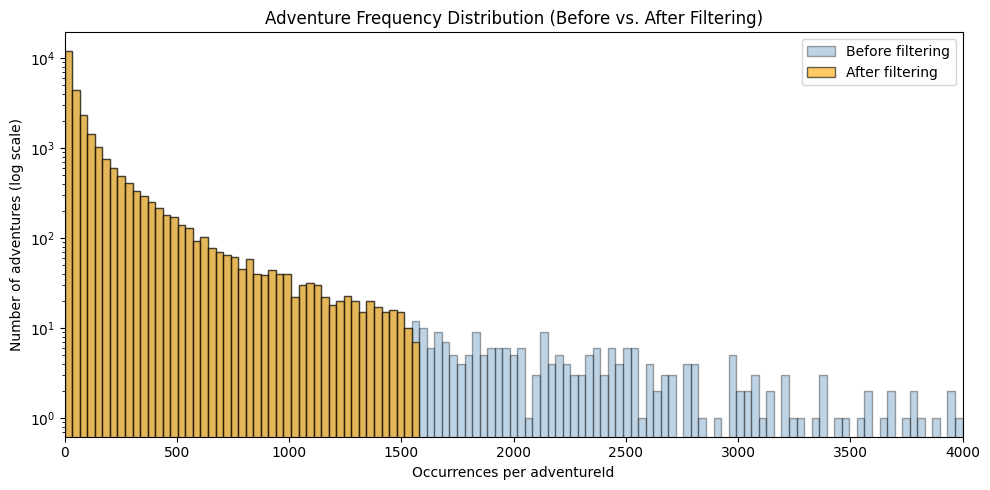

In [41]:
# ---------- Frequency Filtering Visualization (Improved: log scale + unified bins) ----------

adventure_counts = df_clean["adventureId"].value_counts()
q99 = adventure_counts.quantile(0.99)
valid_adventures = adventure_counts[adventure_counts <= q99].index
df_filtered = df_clean[df_clean["adventureId"].isin(valid_adventures)].copy()

print(f"[99th Percentile Threshold]: {q99:.0f}")
print(f"Rows before filtering : {len(df_clean):,}")
print(f"Rows after filtering  : {len(df_filtered):,}")
print(f"Removed adventureIds  : {len(adventure_counts[adventure_counts > q99])}")

# ---------- Plot ----------
plt.figure(figsize=(10, 5))

# Define uniform bins within [0, 4000]
bins = np.linspace(0, 4000, 120)

plt.hist(
    adventure_counts, 
    bins=bins, 
    alpha=0.35, 
    color="steelblue", 
    edgecolor="black", 
    label="Before filtering"
)
plt.hist(
    df_filtered["adventureId"].value_counts(), 
    bins=bins, 
    alpha=0.6, 
    color="orange", 
    edgecolor="black", 
    label="After filtering"
)

plt.xlim(0, 4000)
plt.yscale("log")  # key: use log scale to reveal both curves
plt.xlabel("Occurrences per adventureId")
plt.ylabel("Number of adventures (log scale)")
plt.title("Adventure Frequency Distribution (Before vs. After Filtering)")
plt.legend()
plt.tight_layout()
plt.show()


In [42]:
# Decide NOT to filter
DF = df_clean

In [44]:
print("Rows:", len(DF))
print("Date range:", DF["event_ts"].min(), "→", DF["event_ts"].max())

# Key nulls
cols = ["event_ts","user_id","event_name","content_id","content_status","platform","userAgent","game_phase"]
print("\nNull rates (%):")
print((DF[cols].isna().mean()*100).round(2).sort_values(ascending=False))

# Phase & content status
print("\nGame phase distribution:")
print(DF["game_phase"].value_counts(dropna=False))

print("\nContent status distribution (overall):")
print(DF["content_status"].value_counts(dropna=False))

Rows: 6944203
Date range: 2025-09-26 17:40:24.032000+00:00 → 2025-10-10 17:39:32.656000+00:00

Null rates (%):
content_id        43.82
event_ts           0.00
user_id            0.00
event_name         0.00
content_status     0.00
platform           0.00
userAgent          0.00
game_phase         0.00
dtype: float64

Game phase distribution:
game_phase
in-game     4070473
pre-game    2873730
Name: count, dtype: int64

Content status distribution (overall):
content_status
ok              3901300
no_valid_id     2222396
missing_data     820507
Name: count, dtype: int64


---
# 2. First-Time User Experience (FTUE)

**Definitions**
- **Signup Rate (24h)** = signups within 24h of first seen / eligible new visitors.
- **Day-1 Retention** = % of signup cohort active on day +1 (timezone + watermark).

In [45]:
# ---------- FTUE: Strict Signup & D1 Retention (24–48h window) ----------

# 0) Preconditions: keep rows with valid timestamps
DF = DF[DF["event_ts"].notna()].copy()

# 1) Define explicit signup events (strict)
SIGNUP_EVENTS = {
    "user_email_registered",
    "account_email_registered",
    "user_registered_with_aid",
}

# 2) First seen per user (visitor baseline)
first_seen = (
    DF.groupby("user_id", dropna=False)["event_ts"]
      .min()
      .rename("first_seen")
)

# 3) Signup timestamp per user (strict: explicit events only)
signup_hits = DF[DF["event_name"].isin(SIGNUP_EVENTS)]
signup_ts = (
    signup_hits.groupby("user_id")["event_ts"]
               .min()
               .rename("signup_ts")
)

# 4) Assemble user-level frame
users = pd.concat([first_seen, signup_ts], axis=1)

# Signup rate
users["signed_up"] = users["signup_ts"].notna()
visitors = len(users)
registered_users = int(users["signed_up"].sum())
signup_rate = (registered_users / visitors) if visitors else 0.0

# 5) Day-1 retention: [24h, 48h) after signup
events = DF[["user_id", "event_ts"]].dropna()

users["d1_start"] = users["signup_ts"] + pd.Timedelta("24h")
users["d1_end"]   = users["signup_ts"] + pd.Timedelta("48h")

merged = events.merge(
    users[["d1_start", "d1_end"]],
    left_on="user_id", right_index=True, how="left"
)

mask = (merged["event_ts"] >= merged["d1_start"]) & (merged["event_ts"] < merged["d1_end"])
d1_users = set(merged.loc[mask, "user_id"].astype(str))

users["d1_retained"] = users.index.astype(str).isin(d1_users)

registered = users[users["signed_up"]]
d1_retained = int(registered["d1_retained"].sum())
d1_rate = (d1_retained / len(registered)) if len(registered) else 0.0

# 6) Report
print("FTUE (STRICT — explicit signup events only)")
print(f"Visitors           : {visitors:,}")
print(f"Registered users   : {registered_users:,}")
print(f"Signup rate        : {signup_rate:.4f}")
print(f"D1 retained users  : {d1_retained:,}")
print(f"D1 retention       : {d1_rate:.4f}")


FTUE (STRICT — explicit signup events only)
Visitors           : 66,531
Registered users   : 5,739
Signup rate        : 0.0863
D1 retained users  : 1,298
D1 retention       : 0.2262


### Quick Findings
- **Registered User / Signup Rate is very close 8.6%/10%**
- **D1 Retention Rate is different**

### Question: Do we have any idea why do so many users try AIDungeon but don’t register?

In [47]:
# Registration Friction
FRICTION_EVENTS = {
    "registration_with_email_failed",
    "prompt_login",
    "require_login_sign_in_pressed",
    "login_with_third_party_failed",
    "login_email_error_aidungeon",
}


friction_ts = (
    DF[DF["event_name"].isin(FRICTION_EVENTS)]
    .groupby("user_id")["event_ts"].min()
    .rename("friction_ts")
)


signup_ts = (
    DF[DF["event_name"].isin({
        "user_email_registered", "account_email_registered", "user_registered_with_aid"
    })]
    .groupby("user_id")["event_ts"].min()
    .rename("signup_ts")
)

first_ingame = (
    DF[DF["game_phase"] == "in-game"]
    .groupby("user_id")["event_ts"].min()
    .rename("first_ingame")
)


u = pd.concat([friction_ts, signup_ts, first_ingame], axis=1)
u["friction_exposed"] = u["friction_ts"].notna()


u["lost_interest"] = (
    u["friction_exposed"] &
    u["signup_ts"].isna() &             
    (
        u["first_ingame"].isna() |         
        (u["first_ingame"] < u["friction_ts"])  
    )
)


exposed_total = u["friction_exposed"].sum()
lost_interest = u["lost_interest"].sum()

print(f"Friction-exposed users: {exposed_total:,}")
print(f"Lost interest after friction: {lost_interest:,} ({lost_interest/exposed_total:.1%})")

Friction-exposed users: 6,448
Lost interest after friction: 5,367 (83.2%)


In [48]:
# Registation Prompt Show
PROMPT_EVENTS = {
    "prompt_login",
    "require_login_sign_in_pressed"
}


played_users = set(DF.loc[DF["game_phase"]=="in-game", "user_id"].astype(str))

signup_users = set(DF.loc[
    DF["event_name"].isin({
        "user_email_registered","account_email_registered","user_registered_with_aid"
    }),
    "user_id"
].astype(str))

prompt_users = set(DF.loc[
    DF["event_name"].isin(PROMPT_EVENTS),
    "user_id"
].astype(str))

played_df = pd.DataFrame({
    "user_id": list(played_users)
})
played_df["saw_prompt"] = played_df["user_id"].isin(prompt_users)
played_df["signed_up"] = played_df["user_id"].isin(signup_users)

summary = (
    played_df.groupby("saw_prompt")["signed_up"]
    .agg(["count","sum","mean"])
    .rename(columns={"count":"users","sum":"registered","mean":"signup_rate"})
)

summary["signup_rate"] = (summary["signup_rate"]*100).round(2)
summary = summary.reset_index()
summary["saw_prompt"] = summary["saw_prompt"].map({True:"Saw login prompt", False:"No prompt"})

print(summary)

         saw_prompt  users  registered  signup_rate
0         No prompt  14442        5012        34.70
1  Saw login prompt   1134         240        21.16


In [49]:
# Platform/Devices
SIGNUP_EVENTS = {
    "user_email_registered",
    "account_email_registered",
    "user_registered_with_aid",
}


played_users = set(DF.loc[DF["game_phase"]=="in-game", "user_id"].astype(str))


signup_users = set(DF.loc[DF["event_name"].isin(SIGNUP_EVENTS), "user_id"].astype(str))


platform_by_user = (
    DF.groupby("user_id")["platform"]
    .agg(lambda s: s.dropna().iloc[0] if len(s.dropna()) else "unknown")
)


user_df = pd.DataFrame({
    "user_id": list(played_users),
})
user_df["platform"] = user_df["user_id"].map(platform_by_user)
user_df["signed_up"] = user_df["user_id"].isin(signup_users)


platform_summary = (
    user_df.groupby("platform")["signed_up"]
    .agg(["count","sum","mean"])
    .rename(columns={"count":"users","sum":"registered","mean":"signup_rate"})
    .reset_index()
)

platform_summary["signup_rate"] = (platform_summary["signup_rate"]*100).round(2)
platform_summary = platform_summary.sort_values("users", ascending=False)

print(platform_summary)

  platform  users  registered  signup_rate
4      web  11972        4017        33.55
0  android   1505         558        37.08
3  unknown   1284         271        21.11
1      ios    811         404        49.82
2     none      4           2        50.00


### Quick Findings
- **Need to reduce registration Complexity**
- **User that didn't see prompt tend to register**
- **Mobile platform has a higher registration rate**

---
# 3. Content Performance & Recommendations

**KPIs**
- Exposure, CTR, PlayRate, Actions/Play, ReturnRate (7d). Use empirical-Bayes shrinkage for small samples.


In [56]:
# ---------- STRICT surface propagation (session-based) ----------
# DF must include ['user_id','event_ts','event_name','surface']

# 1) Choose reliable "anchor" events that define the surface
ANCHOR_EVENTS = {"page_viewed"} 

dfu = DF[DF["event_ts"].notna()].copy()
dfu["event_name_norm"] = dfu["event_name"].astype(str).str.lower()
is_anchor = dfu["event_name_norm"].isin(ANCHOR_EVENTS) & (dfu["surface"].ne("unknown"))
dfu = dfu.sort_values(["user_id", "event_ts"]).copy()

# 2) Compute session boundaries (30-min inactivity split)
prev_ts = dfu.groupby("user_id")["event_ts"].shift()
new_session = prev_ts.isna() | ((dfu["event_ts"] - prev_ts) > pd.Timedelta("30min"))
session_id = new_session.groupby(dfu["user_id"]).cumsum()

# 3) Within each (user, session), forward-fill known surface from anchor events
anchor_surface = dfu["surface"].where(is_anchor, np.nan)
surface_ff = anchor_surface.groupby([dfu["user_id"], session_id]).ffill()

# 4) Only fill unknowns
to_fill = dfu["surface"].eq("unknown") & surface_ff.notna()
dfu.loc[to_fill, "surface"] = surface_ff[to_fill].values

print(f"[Surface propagation] filled rows: {to_fill.sum():,}")
print(f"[Surface coverage] known ratio after fill: {(dfu['surface']!='unknown').mean():.2%}")

# 5) Push back to DF (optional)
DF.loc[dfu.index, "surface"] = dfu["surface"]


[Surface propagation] filled rows: 0
[Surface coverage] known ratio after fill: 97.51%


In [59]:
# ---------- 0) Build DF_content (filter + minimal columns) ----------
DF_content = (
    DF.loc[DF["event_ts"].notna() & DF["event_name"].notna(),
           ["user_id","event_ts","event_name","content_id","surface"]]
      .copy()
)

# ---------- 1) Event typing ----------
CONTENT_EVENTS = {
    "impression": {"content_impressed"},
    "click": {"content_clicked"},
    "start": {"content_started", "adventure_started"},
    "action": {
        "submit_button_pressed",
        "take_a_turn_button_pressed",
        "action_roundtrip_completed",
        "retry_button_pressed",
        "erase_button_pressed",
        "edit-action",
        "rewind-to-here",
        "erase-to-here",
    },
}
def classify_event(e: str):
    for k, v in CONTENT_EVENTS.items():
        if e in v:
            return k
    return None

DF_content["etype"] = DF_content["event_name"].map(classify_event)
DF_content = DF_content[DF_content["etype"].notna()].copy()

# ---------- 2) scenario_key  ----------
DF_content = DF_content.sort_values(["user_id","event_ts"]).copy()
scenario_list, current_user, current_scenario = [], None, None
for _, row in DF_content.iterrows():
    uid = row["user_id"]
    if uid != current_user:
        current_user, current_scenario = uid, None
    if (row["etype"] == "start") and pd.notna(row["content_id"]):
        current_scenario = str(row["content_id"])
    scenario_list.append(current_scenario)
DF_content["scenario_key"] = scenario_list

mask_ic = DF_content["etype"].isin(["impression","click"]) & DF_content["content_id"].notna()
DF_content.loc[mask_ic, "scenario_key"] = DF_content.loc[mask_ic, "content_id"].astype(str)
DF_content = DF_content[DF_content["scenario_key"].notna()].copy()

# ---------- 3) Aggregate per ----------
def count_event(series: pd.Series, etype: str) -> int:
    return (series == etype).sum()

agg = (
    DF_content
      .groupby(["scenario_key","surface"], dropna=False)
      .agg(
          impressions=("etype", lambda x: count_event(x, "impression")),
          clicks=("etype",      lambda x: count_event(x, "click")),
          starts=("etype",      lambda x: count_event(x, "start")),
          actions=("etype",     lambda x: count_event(x, "action")),
          users=("user_id","nunique"),
          first_ts=("event_ts","min"),
          last_ts=("event_ts","max"),
      )
      .reset_index()
)

# ---------- 4) Core KPIs (for later summaries) ----------
agg["CTR"]                   = np.where(agg["impressions"] > 0, agg["clicks"] / agg["impressions"], np.nan)
agg["avg_actions_per_player"]= np.where(agg["users"] > 0,       agg["actions"] / agg["users"],       np.nan)

# Q1. Overall criteria

kpi_overall = pd.Series({
    "CTR_mean":    agg["CTR"].mean(skipna=True),
    "CTR_median":  agg["CTR"].median(skipna=True),
    "Depth_mean":  agg["avg_actions_per_player"].mean(skipna=True),
    "Depth_median":agg["avg_actions_per_player"].median(skipna=True),
})
print("\n=== Q1. Overall criteria ===")
print(kpi_overall)


# Q2. Per-scenario leaderboard (by unique users), with CTR
#     and avg depth — collapsed across surfaces

# Unique users per scenario_key (dedup across surfaces)
users_per_scn = DF_content.groupby("scenario_key")["user_id"].nunique().rename("users")

agg_all = (
    agg.groupby("scenario_key", as_index=False)
       .agg(
           impressions=("impressions","sum"),
           clicks=("clicks","sum"),
           actions=("actions","sum"),
       )
       .merge(users_per_scn, on="scenario_key", how="left")
)

# Overall CTR & depth per scenario
agg_all["CTR"]                   = np.where(agg_all["impressions"] > 0, agg_all["clicks"]/agg_all["impressions"], np.nan)
agg_all["avg_actions_per_player"]= np.where(agg_all["users"] > 0,       agg_all["actions"]/agg_all["users"],       np.nan)

leaderboard = (
    agg_all.sort_values(["users","impressions"], ascending=False)
           .head(20)[["scenario_key","users","CTR","avg_actions_per_player","impressions","clicks","actions"]]
)

print("\n=== Q2. Top scenarios by unique users (with CTR & depth) ===")
print(leaderboard)


# Q3. Per-surface summary: avg CTR, avg depth, contents count

surface_summary = (
    agg.groupby("surface", dropna=False)
       .agg(
           contents=("scenario_key","nunique"),
           mean_ctr=("CTR","mean"),
           mean_depth=("avg_actions_per_player","mean"),
       )
       .reset_index()
       .sort_values(["contents"], ascending=False)
)

print("\n=== Q3. Per-surface summary (avg CTR, avg depth, #contents) ===")
print(surface_summary)



=== Q1. Overall criteria ===
CTR_mean         0.277152
CTR_median       0.111111
Depth_mean      39.034581
Depth_median     6.000000
dtype: float64

=== Q2. Top scenarios by unique users (with CTR & depth) ===
      scenario_key  users       CTR  avg_actions_per_player  impressions  \
4536  cj90vvdB14fn   2421  0.172311              120.719950        11398   
2472  KyMhfQFXO8Bs   1392  0.199461              299.230603        14093   
3973  Yo_hMuEXJQQI    943  0.141905               31.687169         3150   
2725  NHwBA3B_45FL    491  0.139597               34.175153         2235   
4595  dC70aiOtlPX8    446  0.130687               51.428251         2242   
5403  kI0Cr6VlP0dS    384  0.117431               54.041667         1635   
3000  Q1hBKTx3ubGx    355  0.145234               14.904225         1322   
5522  lJzhnZ2ToBU1    283  0.130802               55.547703         1185   
550   3qWxqEvpEHnF    185  0.146950              194.848649         2164   
1967  GfSFYLBR0lky    165  0.

### Quick Findings
- **Overall: CTR averages ~27.7% (median 11.1%), while depth is heavy-tailed (mean ~39 actions/player vs median 6), indicating a small set of highly engaging experiences.**
- **Top content: The most-visited scenarios pair mid CTR (0.14–0.20) with very high depth (often >100 actions/player), suggesting strong payoff once users start.**
- **By surface: Search drives the highest CTR but shallow depth; Homepage shows similar CTR with much deeper sessions**

# 4. Final Summary

### 1. Key Findings

#### Data Quality
- `content_id` missing for **43.8 %** of events; `path` coverage initially only **5.4 %**, restored to **97.5 %** after session-based propagation.  
- ~27 K duplicate events detected via composite keys (`user_id`, `event_name`, `event_ts`, `content`) → weak de-duplication.  
- Standardizing event dictionaries and fixing attribution fields should precede any modeling or reporting.

#### First-Time User Experience
- **Signup rate = 8.6 %**, **D1 retention = 22.6 %**, both listed benchmarks.  
- Users encountering registration friction (errors or prompts) churned at **83 %**; uninterrupted players converted **34.7 % vs 21.2 %**.  
- Platform split: **iOS 49.8 % > Android 37.1 % > Web 33.6 %**.

#### Content Performance
- Overall **CTR = 27.7 % (mean), 11.1 % (median)**; average depth ≈ 39 actions / user (median 6).  
- **Search** surfaces drive higher CTR but shallow sessions; **Home/Content** surfaces show deeper engagement.  
- Top scenarios (e.g., `cj90vvdB14fn`, `KyMhfQFXO8Bs`) combine moderate CTR with exceptionally high depth (> 100 actions / player).

---

### 2. Recommendations & Next Steps

- Data | Fix missing fields, remove duplicates, improve event tracking.
- Onboarding | Simplify signup flow, delay login walls, track signup funnel steps.
- Content | Rank content by CTR × depth, test lightweight recommendation logic.

---

### 4. Summary
Improving **data completeness** and **reducing registration friction** will yield the fastest ROI.  
Once event reliability is ensured, adaptive recommendation and login-wall logic can unlock stronger retention and creator-user network effects.
